# **RAVELIN ASSESSMENT**

---






### **Import Libraries**

---



In [1]:
import json
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from pandas import read_csv
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

### **Convert JSON file to dataframe**

---



In [2]:
with open('customers.json',encoding='utf-8-sig')as json_data:
    d = json.load(json_data)
    #---Create a row for every transaction with the foreign key id orderID, paymentMethodId and primary key id transactionId----#
    df = pd.DataFrame([], columns = ['customerEmail', 'customerPhone','customerDevice','customerIPAddress','customerBillingAddress','transactionId','orderId','paymentMethodId','transactionAmount','transactionFailed','orderAmount','orderState','orderShippingAddress','paymentMethodRegistrationFailure','paymentMethodType','paymentMethodProvider','paymentMethodIssuer','fraudulent'])
    #---Iterate through all records in the JSON file---#
    for i in range(len(d)):
      fraudulent = d[i]["fraudulent"]
      customerEmail = d[i]["customer"]["customerEmail"]
      customerPhone = d[i]["customer"]["customerPhone"]
      customerDevice = d[i]["customer"]["customerDevice"]
      customerIPAddress = d[i]["customer"]["customerIPAddress"]
      customerBillingAddress = d[i]["customer"]["customerBillingAddress"]
      #---Retrieve all transactions---#
      for j in d[i]["transactions"]: 
        transactionId = j["transactionId"]
        orderId_trans = j["orderId"]
        paymentMethodId_trans = j["paymentMethodId"]
        transactionAmount = j["transactionAmount"]
        transactionFailed = j["transactionFailed"]
        #---For every transaction find the corresponding order---#
        for j in d[i]["orders"]:
          if orderId_trans == j["orderId"]:
            orderId = j["orderId"]
            orderAmount = j["orderAmount"]
            orderState = j["orderState"]
            orderShippingAddress = j["orderShippingAddress"]
        #---For every transaction find the corresponding payment method---#
        for j in d[i]["paymentMethods"]:
          if paymentMethodId_trans == j["paymentMethodId"]:
            paymentMethodId = j["paymentMethodId"]
            paymentMethodRegistrationFailure = j["paymentMethodRegistrationFailure"]
            paymentMethodType = j["paymentMethodType"]
            paymentMethodProvider = j["paymentMethodProvider"]
            paymentMethodIssuer = j["paymentMethodIssuer"]
        #---Append to the dataframe---#
        df = df.append({'customerEmail':customerEmail, 'customerPhone':customerPhone,'customerDevice':customerDevice,'customerIPAddress':customerIPAddress,'customerBillingAddress':customerBillingAddress,'transactionId':transactionId,'orderId':orderId,'paymentMethodId':paymentMethodId,'transactionAmount':transactionAmount,'transactionFailed':transactionFailed,'orderAmount':orderAmount,'orderState':orderState,'orderShippingAddress':orderShippingAddress,'paymentMethodRegistrationFailure':paymentMethodRegistrationFailure,'paymentMethodType':paymentMethodType,'paymentMethodProvider':paymentMethodProvider,'paymentMethodIssuer':paymentMethodIssuer,'fraudulent':fraudulent},ignore_index=True)
      

**Shape and size of the dataset**

In [3]:
print("Shape of the dataset: {}".format(df.shape))
print("Size of the dataset: {}".format(df.size))

Shape of the dataset: (623, 18)
Size of the dataset: 11214


**First 5 rows of the dataset**

In [4]:
df.head()

,customerEmail,customerPhone,customerDevice,customerIPAddress,customerBillingAddress,transactionId,orderId,paymentMethodId,transactionAmount,transactionFailed,orderAmount,orderState,orderShippingAddress,paymentMethodRegistrationFailure,paymentMethodType,paymentMethodProvider,paymentMethodIssuer,fraudulent
0,josephhoward@yahoo.com,400-108-5415,yyeiaxpltf82440jnb3v,8.129.104.40,"5493 Jones Islands\nBrownside, CA 51896",a9lcj51r,vjbdvd,wt07xm68b,18,False,18,pending,"5493 Jones Islands\nBrownside, CA 51896",True,card,JCB 16 digit,Citizens First Banks,False
1,josephhoward@yahoo.com,400-108-5415,yyeiaxpltf82440jnb3v,8.129.104.40,"5493 Jones Islands\nBrownside, CA 51896",y4wcv03i,yp6x27,wt07xm68b,26,False,26,fulfilled,"5493 Jones Islands\nBrownside, CA 51896",True,card,JCB 16 digit,Citizens First Banks,False
2,evansjeffery@yahoo.com,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,5mi94sfw,nlghpa,41ug157xz,45,False,45,fulfilled,"898 Henry Ports\nNew Keithview, CA 95893-2497",False,bitcoin,American Express,Bastion Banks,True
3,evansjeffery@yahoo.com,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,br8ba1nu,uw0eeb,41ug157xz,23,False,23,fulfilled,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,False,bitcoin,American Express,Bastion Banks,True
4,evansjeffery@yahoo.com,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,a33145ss,bn44oh,y3xp697jx,43,True,43,fulfilled,"5093 Bryan Forks\nJoshuaton, FM 01565-9801",True,bitcoin,VISA 16 digit,Solace Banks,True


### **Analysis of the dataset**

---



*Based on the below table we can summarize the number of unique values, high frequency values for every attribute*

In [5]:
df.describe()

,customerEmail,customerPhone,customerDevice,customerIPAddress,customerBillingAddress,transactionId,orderId,paymentMethodId,transactionAmount,transactionFailed,orderAmount,orderState,orderShippingAddress,paymentMethodRegistrationFailure,paymentMethodType,paymentMethodProvider,paymentMethodIssuer,fraudulent
count,623,623,623,623,623,623,623,623,623,623,623,623,623,623,623,623,623,623
unique,136,141,141,138,139,623,478,237,67,2,67,3,274,2,4,10,19,2
top,johnlowery@gmail.com,1-321-386-6855x0101,72stamnugxuz9ls1xx98,45.203.99.249,Unit 6719 Box 6044\nDPO AE 33534,0rtt6tgw,93lzyc,4nf29mjz1,14,False,14,fulfilled,USS Barr\nFPO AE 16052-3851,False,card,JCB 16 digit,Her Majesty Trust,False
freq,28,15,15,21,15,1,7,15,24,455,24,516,8,541,479,118,66,366




---



*In our dataset, we have attributes which are not numerical and hence performing analysis before pre-processing is ideally not feasible. We will have a look on how **'fraudulent'** attribute is dependant on other attributes by performing value_counts()*

In [6]:
print(df.groupby('paymentMethodIssuer').fraudulent.value_counts())

paymentMethodIssuer       fraudulent
B                         True          10
Bastion Banks             False         35
                          True          23
Bulwark Trust Corp.       True          32
                          False         27
Citizens First Banks      True          29
                          False         26
Fountain Financial Inc.   False         34
                          True          26
Grand Credit Corporation  False         41
                          True          14
Her Majesty Trust         False         56
                          True          10
His Majesty Bank Corp.    False         44
                          True          21
Rose Bancshares           False         31
                          True          28
Solace Banks              False         27
                          True          14
Vertex Bancorp            False         45
                          True          18
a                         True           4
c                

*From the above results, we can conclude that **paymentMethodIssuer** which doesn't have a proper legal name are fraudulent transactions*

In [7]:
df.groupby('fraudulent').paymentMethodRegistrationFailure.value_counts()

fraudulent  paymentMethodRegistrationFailure
False       False                               321
            True                                 45
True        False                               220
            True                                 37
Name: paymentMethodRegistrationFailure, dtype: int64

In [8]:
df.groupby('paymentMethodProvider').fraudulent.value_counts()

paymentMethodProvider        fraudulent
American Express             False         28
                             True          17
Diners Club / Carte Blanche  False         38
                             True          20
Discover                     False         24
                             True          17
JCB 15 digit                 False         31
                             True          14
JCB 16 digit                 False         67
                             True          51
Maestro                      False         53
                             True          16
Mastercard                   False         20
                             True          12
VISA 13 digit                True          33
                             False         25
VISA 16 digit                False         51
                             True          45
Voyager                      True          32
                             False         29
Name: fraudulent, dtype: int64

In [9]:
df.groupby('paymentMethodType').fraudulent.value_counts()

paymentMethodType  fraudulent
apple pay          False          27
                   True           22
bitcoin            True           24
                   False          23
card               False         276
                   True          203
paypal             False          40
                   True            8
Name: fraudulent, dtype: int64

*From the above analysis, we can conclude that payment made through **'paypal'** is more reliable compared to other means of payment*


---



### **Preprocessing of the dataset**

---



*Few attributes like customerPhone, customerEmail etc. are not relavant to our analysis and hence can be removed from further processing. If every customer had unique ID, it would have given us an extra piece of information to cluster and see how many fraudulent transactions are made by every customer.*

In [10]:
del df['customerPhone']
del df['customerEmail']
del df['customerDevice']
del df['customerIPAddress']
del df['customerBillingAddress']
del df['orderShippingAddress']
del df['orderAmount'] #--Redundant attribute with transactionAmount--#
#--Keys: It is not useful for analysis since it contains no useful information--#
del df['orderId'] 
del df['paymentMethodId']
del df['transactionId']

In [11]:
df.head()

,transactionAmount,transactionFailed,orderState,paymentMethodRegistrationFailure,paymentMethodType,paymentMethodProvider,paymentMethodIssuer,fraudulent
0,18,False,pending,True,card,JCB 16 digit,Citizens First Banks,False
1,26,False,fulfilled,True,card,JCB 16 digit,Citizens First Banks,False
2,45,False,fulfilled,False,bitcoin,American Express,Bastion Banks,True
3,23,False,fulfilled,False,bitcoin,American Express,Bastion Banks,True
4,43,True,fulfilled,True,bitcoin,VISA 16 digit,Solace Banks,True


*Attributes: **['paymentMethodProvider', 'paymentMethodIssuer', 'orderState', 'paymentMethodType']** are nominal attributes. Removing these attributes will decrease the model performance. These attributes have less unique values and will prove to be useful in predicting whether the transaction is fraudulent or not*

In [12]:
df['paymentMethodProvider'].unique()

array(['JCB 16 digit', 'American Express', 'VISA 16 digit', 'Discover',
       'Voyager', 'VISA 13 digit', 'Maestro', 'Mastercard',
       'Diners Club / Carte Blanche', 'JCB 15 digit'], dtype=object)

In [13]:
df['paymentMethodIssuer'].unique()

array(['Citizens First Banks', 'Bastion Banks', 'Solace Banks',
       'His Majesty Bank Corp.', 'Grand Credit Corporation', 'p', 'x',
       'Bulwark Trust Corp.', 'Her Majesty Trust', 'c', 'Vertex Bancorp',
       'a', 'Fountain Financial Inc.', 'Rose Bancshares', 'r', 'B', 'e',
       'n', 'o'], dtype=object)

In [14]:
df['orderState'].unique()

array(['pending', 'fulfilled', 'failed'], dtype=object)

In [15]:
df['paymentMethodType'].unique()

array(['card', 'bitcoin', 'apple pay', 'paypal'], dtype=object)

*The attributes mentioned above are nominal and don't have any specific order or ratings for it's values so we will go with one-hot encoding method*

In [16]:
one_hot_1 = pd.get_dummies(df['paymentMethodProvider'])
df = df.drop('paymentMethodProvider',axis = 1)
df = df.join(one_hot_1)

In [17]:
one_hot_2 = pd.get_dummies(df['paymentMethodIssuer'])
df = df.drop('paymentMethodIssuer',axis = 1)
df = df.join(one_hot_2)

In [18]:
one_hot_3 = pd.get_dummies(df['paymentMethodType'])
df = df.drop('paymentMethodType',axis = 1)
df = df.join(one_hot_3)

In [19]:
one_hot_4 = pd.get_dummies(df['orderState'])
df = df.drop('orderState',axis = 1)
df = df.join(one_hot_4)

*The Boolean attributes **['transactionFailer', 'paymentMethodRegistrationFailure', 'fraudulent']** must be converted to boolean integers*

In [20]:
df["transactionFailed"] = df["transactionFailed"].astype(int)
df["paymentMethodRegistrationFailure"] = df["paymentMethodRegistrationFailure"].astype(int)
df['fraudulent'] = df['fraudulent'].astype(int)

In [21]:
df.head()

,transactionAmount,transactionFailed,paymentMethodRegistrationFailure,fraudulent,American Express,Diners Club / Carte Blanche,Discover,JCB 15 digit,JCB 16 digit,Maestro,Mastercard,VISA 13 digit,VISA 16 digit,Voyager,B,Bastion Banks,Bulwark Trust Corp.,Citizens First Banks,Fountain Financial Inc.,Grand Credit Corporation,Her Majesty Trust,His Majesty Bank Corp.,Rose Bancshares,Solace Banks,Vertex Bancorp,a,c,e,n,o,p,r,x,apple pay,bitcoin,card,paypal,failed,fulfilled,pending
0,18,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,26,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,45,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,23,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,43,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


*Now we will analyse the correlation between attributes that we have got after pre-processing*

In [22]:
def df_to_plotly(df):
    return {'z': df.values.tolist(),
            'x': df.columns.tolist(),
            'y': df.index.tolist() }
import plotly.graph_objects as go
dfNew = df.corr()
fig = go.Figure(data=go.Heatmap(df_to_plotly(dfNew)))
fig.show()

In [23]:
df.corr()

,transactionFailed,paymentMethodRegistrationFailure,fraudulent,American Express,Diners Club / Carte Blanche,Discover,JCB 15 digit,JCB 16 digit,Maestro,Mastercard,VISA 13 digit,VISA 16 digit,Voyager,B,Bastion Banks,Bulwark Trust Corp.,Citizens First Banks,Fountain Financial Inc.,Grand Credit Corporation,Her Majesty Trust,His Majesty Bank Corp.,Rose Bancshares,Solace Banks,Vertex Bancorp,a,c,e,n,o,p,r,x,apple pay,bitcoin,card,paypal,failed,fulfilled,pending
transactionFailed,1.000000,-0.001202,-0.068354,-0.001884,0.066714,0.086704,0.054004,-0.072187,-0.006993,-0.026695,0.066714,-0.079019,-0.029810,-0.020049,0.066714,0.038168,-0.048847,-0.075765,-0.048847,0.072892,0.088407,0.001110,-0.044581,-0.011862,-0.048847,0.003856,-0.064775,-0.024364,-0.034484,-0.024364,0.014148,-0.003562,-0.002868,-0.022928,0.041453,-0.039929,-0.035855,-0.030170,0.086609
paymentMethodRegistrationFailure,-0.001202,1.000000,0.030605,0.056435,0.054999,0.049853,-0.108630,-0.042789,0.013890,-0.090592,0.234736,-0.034660,-0.128264,-0.049725,-0.043039,-0.061060,-0.054208,0.243057,-0.104413,-0.134015,0.006906,0.149735,0.088150,-0.020348,-0.031296,-0.041502,0.048587,-0.015610,-0.022094,-0.015610,-0.038392,-0.031296,-0.060838,0.230356,-0.056837,-0.076876,-0.020348,0.026227,-0.014665
fraudulent,-0.068354,0.030605,1.000000,-0.019692,-0.044057,0.001140,-0.057478,0.019327,-0.129496,-0.017735,0.101820,0.048750,0.075001,0.152421,-0.010393,0.085314,0.072536,0.013802,-0.099856,-0.182505,-0.062011,0.040771,-0.038310,-0.086397,0.095931,0.127213,0.127213,0.047850,0.067724,0.047850,0.117681,0.095931,0.021639,0.056934,0.041789,-0.144293,0.010936,0.044432,-0.078280
American Express,-0.001884,0.056435,-0.019692,1.000000,-0.089399,-0.074058,-0.077855,-0.134877,-0.098472,-0.064927,-0.089399,-0.119089,-0.091926,-0.035638,0.209351,-0.026717,0.088019,-0.091089,0.000596,-0.035606,-0.095232,0.057989,-0.024044,-0.011323,-0.022430,-0.029744,-0.029744,-0.011188,-0.015835,-0.011188,-0.027515,-0.022430,0.217914,-0.032748,-0.067640,-0.080617,0.029809,-0.020900,-0.004312
Diners Club / Carte Blanche,0.066714,0.054999,-0.044057,-0.089399,1.000000,-0.085039,-0.089399,-0.154876,-0.113073,-0.074554,-0.102655,-0.136748,-0.105557,-0.040922,-0.045621,0.047302,0.075541,-0.048420,-0.080229,-0.074391,0.215921,-0.028163,0.004077,-0.034175,-0.025756,-0.034155,0.070665,-0.012847,-0.018183,-0.012847,-0.031595,-0.025756,0.008992,0.054893,-0.020886,-0.030425,-0.015852,-0.073797,0.127294
Discover,0.086704,0.049853,0.001140,-0.074058,-0.085039,1.000000,-0.074058,-0.128300,-0.093670,-0.061761,-0.085039,-0.113282,-0.087443,0.069123,-0.085039,0.046809,-0.082592,0.045014,0.008680,0.097948,-0.005881,-0.063736,-0.070447,-0.046080,-0.021336,0.340214,-0.028294,-0.010642,0.099376,-0.010642,-0.026174,-0.021336,-0.077548,0.169300,-0.023392,-0.052410,-0.046080,0.000716,0.053172
JCB 15 digit,0.054004,-0.108630,-0.057478,-0.077855,-0.089399,-0.074058,1.000000,-0.134877,-0.098472,-0.064927,-0.089399,-0.119089,-0.091926,-0.035638,0.145333,0.206224,-0.064970,0.056036,-0.086826,-0.096048,-0.014098,0.079165,-0.074058,-0.093588,-0.022430,-0.029744,-0.029744,-0.011188,-0.015835,-0.011188,-0.027515,-0.022430,-0.081524,-0.079704,0.108862,-0.010861,-0.052455,0.011980,0.044092
JCB 16 digit,-0.072187,-0.042789,0.019327,-0.134877,-0.154876,-0.128300,-0.134877,1.000000,-0.170594,-0.112480,-0.154876,-0.206313,-0.159255,-0.061740,0.028400,-0.016438,0.123928,0.119913,-0.034905,0.033266,-0.071176,-0.100382,0.053436,-0.053434,-0.038858,-0.051529,-0.051529,-0.019382,-0.027432,-0.019382,0.078168,-0.038858,-0.065145,-0.029503,0.002667,0.090766,0.041678,-0.007967,-0.037317
Maestro,-0.006993,0.013890,-0.129496,-0.098472,-0.113073,-0.093670,-0.098472,-0.170594,1.000000,-0.082120,-0.113073,-0.150626,-0.116270,-0.045075,-0.095471,-0.079209,-0.037706,-0.097873,0.016379,-0.038387,0.113790,-0.061741,0.030098,0.237886,-0.028370,-0.037621,0.205006,-0.014151,-0.020028,-0.014151,-0.034802,-0.028370,0.010888,-0.062078,-0.012756,0.070656,-0.033548,0.025098,0.0025

*With the correlation map and correlation values we can observe that there is no correlation between any two given attributes*

In [24]:
list(df.columns)

['transactionAmount',
 'transactionFailed',
 'paymentMethodRegistrationFailure',
 'fraudulent',
 'American Express',
 'Diners Club / Carte Blanche',
 'Discover',
 'JCB 15 digit',
 'JCB 16 digit',
 'Maestro',
 'Mastercard',
 'VISA 13 digit',
 'VISA 16 digit',
 'Voyager',
 'B',
 'Bastion Banks',
 'Bulwark Trust Corp.',
 'Citizens First Banks',
 'Fountain Financial Inc.',
 'Grand Credit Corporation',
 'Her Majesty Trust',
 'His Majesty Bank Corp.',
 'Rose Bancshares',
 'Solace Banks',
 'Vertex Bancorp',
 'a',
 'c',
 'e',
 'n',
 'o',
 'p',
 'r',
 'x',
 'apple pay',
 'bitcoin',
 'card',
 'paypal',
 'failed',
 'fulfilled',
 'pending']

In [25]:
cols = ['transactionAmount',
 'transactionFailed',
 'paymentMethodRegistrationFailure',
 'American Express',
 'Diners Club / Carte Blanche',
 'Discover',
 'JCB 15 digit',
 'JCB 16 digit',
 'Maestro',
 'Mastercard',
 'VISA 13 digit',
 'VISA 16 digit',
 'Voyager',
 'B',
 'Bastion Banks',
 'Bulwark Trust Corp.',
 'Citizens First Banks',
 'Fountain Financial Inc.',
 'Grand Credit Corporation',
 'Her Majesty Trust',
 'His Majesty Bank Corp.',
 'Rose Bancshares',
 'Solace Banks',
 'Vertex Bancorp',
 'a',
 'c',
 'e',
 'n',
 'o',
 'p',
 'r',
 'x',
 'apple pay',
 'bitcoin',
 'card',
 'paypal',
 'failed',
 'fulfilled',
 'pending']


### **Machine learning Models**

---



***Segregate predictors vs target attributes***

In [26]:
X=df[cols]
Y=df['fraudulent']

**Check for target balancing and fix it if found imbalanced**

In [27]:
df.fraudulent.value_counts()

0    366
1    257
Name: fraudulent, dtype: int64

Based on the above results we can say that there is no class imbalance problem here

**Perform train-test split**

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

**Logistic regression** 

In [35]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

**Logistic Regression - Classification Accuracy, Classification Report, ROC curve - Test data**

In [36]:
y_pred_logistic_regression = logistic_regression.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(logistic_regression.score(X_test, Y_test)))

Accuracy of logistic regression classifier on test set: 0.765


In [37]:
print(classification_report(Y_test, y_pred_logistic_regression))

              precision    recall  f1-score   support

           0       0.80      0.81      0.81       112
           1       0.71      0.69      0.70        75

    accuracy                           0.76       187
   macro avg       0.76      0.75      0.75       187
weighted avg       0.76      0.76      0.76       187



*The recall and precision value for the model is quite good for the dataset that we have used. Out of 187 records, there are 44 misclassifications. The area under ROC curve is 0.75 which is considered to be a fair model*

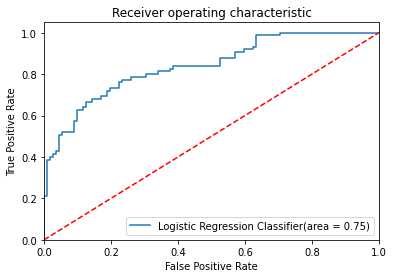

In [38]:
logit_roc_auc = roc_auc_score(Y_test, logistic_regression.predict(X_test))
fpr, tpr, thresholds = roc_curve(Y_test, logistic_regression.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression Classifier(area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

**Feature Importance**

*Now we will calculate the feature importance of the logistic regression model, this can be done by retrieving the coefficients of individual features*

In [39]:
feature_importance = logistic_regression.coef_
feature_importance

array([[ 0.06260474, -0.08090855, -0.14062744, -0.03771953, -0.30792088,
         0.34241812, -0.97955968,  0.02551178, -0.75783732,  0.16459792,
         0.58898617,  0.06924509,  0.88945935,  1.12279677, -0.04569035,
        -0.17543415,  0.05156429, -0.54976686, -1.06974697, -2.21359337,
        -0.96243887, -0.4761324 , -1.06930723, -1.12355038,  0.59018205,
         1.39045086,  1.23464721,  0.55888062,  0.59379424,  0.51047756,
         1.04693937,  0.58310861,  0.00375613,  0.4123391 ,  0.266129  ,
        -0.68504323, -0.01038206,  0.22713724, -0.21957417]])

In [40]:
for i in range(len(feature_importance[0])):
	print('%0s : %.5f' % (cols[i],feature_importance[0][i]))

transactionAmount : 0.06260
transactionFailed : -0.08091
paymentMethodRegistrationFailure : -0.14063
American Express : -0.03772
Diners Club / Carte Blanche : -0.30792
Discover : 0.34242
JCB 15 digit : -0.97956
JCB 16 digit : 0.02551
Maestro : -0.75784
Mastercard : 0.16460
VISA 13 digit : 0.58899
VISA 16 digit : 0.06925
Voyager : 0.88946
B : 1.12280
Bastion Banks : -0.04569
Bulwark Trust Corp. : -0.17543
Citizens First Banks : 0.05156
Fountain Financial Inc. : -0.54977
Grand Credit Corporation : -1.06975
Her Majesty Trust : -2.21359
His Majesty Bank Corp. : -0.96244
Rose Bancshares : -0.47613
Solace Banks : -1.06931
Vertex Bancorp : -1.12355
a : 0.59018
c : 1.39045
e : 1.23465
n : 0.55888
o : 0.59379
p : 0.51048
r : 1.04694
x : 0.58311
apple pay : 0.00376
bitcoin : 0.41234
card : 0.26613
paypal : -0.68504
failed : -0.01038
fulfilled : 0.22714
pending : -0.21957


*The coeffeicient values gives the importance of every feature in the model. Say if there is a transaction for which the issuer is 'Her Majesty trust' then there is more probablity of the transaction being genuine because the feature has more negative coefficient value which might take down the summation value nearer to zero (not fraudulent)*

The top 3 decisive attributes in the model are:
1.  Her Majesty Trust [Boolean]
2.  c [Boolean]
3.  e [Boolean]

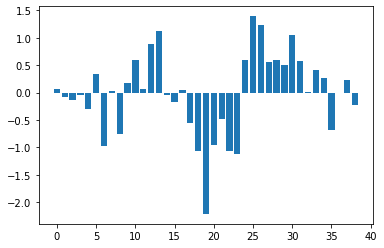

In [41]:
plt.bar([x for x in range(39)], feature_importance[0])
plt.show()



---



**Random Forest Classifier** 

In [29]:
random_forest=RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train,Y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

**Random Forest Classifier - Classification Accuracy, Confusion Matrix, Classification Report, ROC curve - Test data**

In [30]:
y_pred_random_forest=random_forest.predict(X_test)
print('Accuracy of random forest classifier on test set: {:.3f}'.format(random_forest.score(X_test, Y_test)))

Accuracy of random forest classifier on test set: 0.861


In [31]:
confusion_matrix = confusion_matrix(Y_test, y_pred_random_forest)
print(confusion_matrix)

[[108   4]
 [ 22  53]]


The false positive and false negative rates are less which is a good indication for model performance

In [32]:
print(classification_report(Y_test, y_pred_random_forest))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89       112
           1       0.93      0.71      0.80        75

    accuracy                           0.86       187
   macro avg       0.88      0.84      0.85       187
weighted avg       0.87      0.86      0.86       187



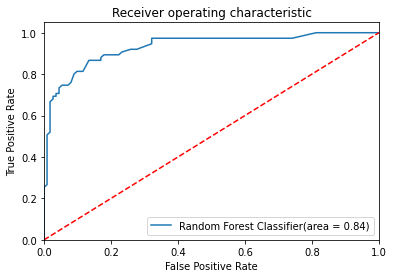

In [33]:
rfc_roc_auc = roc_auc_score(Y_test, random_forest.predict(X_test))
fpr, tpr, thresholds = roc_curve(Y_test, random_forest.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest Classifier(area = %0.2f)' % rfc_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

*The precision, recall, ROC values are good for random forest model compared to the logistic regression model. Random forest outperformed logistic regression as it can perform well with more categorical data. In our analysis, we have a dataset which has more categorical features and hence random forest performs well. Random selection in individual decision trees built helps in retrieving the complex features patterns providing better metrics*

**Feature Importance**

*The most decisive attribute here is 'transactionAmount', this is the root branch from which we make further decisions. From the below results, you can see the order of importance of the attributes*

In [34]:
feature_imp = pd.Series(random_forest.feature_importances_,index=cols).sort_values(ascending=False)
feature_imp

transactionAmount                   0.341055
Her Majesty Trust                   0.033639
VISA 16 digit                       0.029149
Vertex Bancorp                      0.026397
paymentMethodRegistrationFailure    0.025942
transactionFailed                   0.025897
Bulwark Trust Corp.                 0.024678
Voyager                             0.023655
VISA 13 digit                       0.022839
Rose Bancshares                     0.022594
Bastion Banks                       0.021385
card                                0.021235
Citizens First Banks                0.020610
JCB 16 digit                        0.019731
Fountain Financial Inc.             0.019425
Solace Banks                        0.019314
American Express                    0.019297
JCB 15 digit                        0.018656
Diners Club / Carte Blanche         0.018574
His Majesty Bank Corp.              0.018056
Maestro                             0.017930
fulfilled                           0.017659
Grand Cred

**Conclusion**

1. Conversion of JSON file to dataframe
2. Data Summarization
3. Data Pre-processing
4. Data Analysis
5. Machine learning model
   * Logistic Regression classifier
   * Random Forest Classifier

The data provided has less informative features which is probably one of the reason to not get greater accuracy value. Random forest classifier works best with this dataset because of the decision trees built. Random forest outperformed logistic regression as it can perform well with more categorical data. In our analysis, we have a dataset which has more categorical features and hence random forest performs well. Random selection in individual decision trees built helps in retrieving the complex features patterns providing better metrics. It is necessary to convert nominal attribtes to one-hot encoding, converting them into category integers will give discrepancies in the end result (i.e card-0, apple pay-1, paypal-2..: The model will consider this as rating and hence this method is not preferred)

**What would I do if more time was provided**

1. Make more univariate, bivariate, multivariate analysis of the dataset given
2. Try to build more algorithms to find out which model works best for this use case
3. Perform more sophisticated data pre-processing techniques if it proves to be useful